In [40]:
#!/usr/bin/env python
# coding: utf-8
import sys
sys.path.append('..')
import umbrella_mesh
import elastic_rods
import linkage_vis
from umbrella_mesh import UmbrellaEnergyType
from bending_validation import suppress_stdout as so
from visualization_helper import *

import pipeline_helper, importlib, design_optimization_analysis
with so(): importlib.reload(pipeline_helper)
with so(): importlib.reload(design_optimization_analysis)

from pipeline_helper import UmbrellaOptimizationCallback, allEnergies, allGradientNorms, allDesignObjectives, allDesignGradientNorms, set_joint_vector_field, show_center_joint_normal, show_joint_normal

from design_optimization_analysis import DesignOptimizationAnalysis

import umbrella_optimization
import umbrella_optimization_finite_diff
from umbrella_optimization import OptEnergyType

import numpy as np
import numpy.linalg as la

import pickle, gzip

from configuration import *


import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

### Initialization

In [41]:
name = 'igloo_bdry'
input_path = '../../data/{}.json.gz'.format(name)
# import json, gzip
# flat_data = json.load(gzip.open(input_path))
# hemi_data = json.load(gzip.open('../../data/igloo.json.gz'))
# flat_data['target_v'], flat_data['target_f'] = hemi_data['target_v'], hemi_data['target_f']
# with gzip.open(input_path, 'wt') as outfile:
#     json.dump(flat_data, outfile, indent=4)


handleBoundary = True
io, input_data, target_mesh, curr_um, thickness, target_height_multiplier = parse_input(input_path, handleBoundary = handleBoundary)
print(curr_um.numUmbrellas())
# target_height_multiplier = 1
# curr_um = pickle.load(gzip.open('../../data/optim/flat_optimized_equilibrium_2022_01_23_23_15_target_height_factor_5.0.pkl.gz', 'r'))

57


#### Pin Rigid Motion

In [42]:
use_pin = False

driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

In [43]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1
OPTS.beta = 1e-6
OPTS.niter = 300
OPTS.verboseNonPosDef = False

rod_colors = get_color_field(curr_um, input_data)

# lview = linkage_vis.LinkageViewer(curr_um, width=1024, height=600)
# lview.update(scalarField = rod_colors)
# lview.show()

import mesh
view = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh, width=1024, height=600)
set_surface_view_options(view, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
view.averagedMaterialFrames = True
view.showScalarField(rod_colors)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

In [44]:
view.getCameraParams()

view.getSize()

(1024, 600)

In [45]:
# from load_jsondata import write_deformed_config
# import time, json, gzip
# output_path = '../../data/optim/{}_unoptimized_rendering_output_{}.json.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"))
# write_deformed_config(curr_um, input_path, output_path, write_stress = False, is_rest_state = True, handleBoundary = handleBoundary)

In [46]:
from equilibrium_solve_analysis import EquilibriumSolveAnalysis
eqays = EquilibriumSolveAnalysis(curr_um)
def eqm_callback(prob, i):
    eqays.record(prob)
    if (i % 2 == 0):
        view.showScalarField(rod_colors)

configure_umbrella_pre_deployment(curr_um, thickness, target_height_multiplier)
# curr_um.scaleInputPosWeights(0)
# curr_um.attractionWeight = 0


allGradientNorms(curr_um)

{'Full': 0.002150005040381639,
 'Elastic': 3.2478415052064913e-12,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0021498589416371907,
 'AngleBoundPenalty': 2.5064003082914304e-05}

In [47]:
break_input_angle_symmetry(curr_um)

view.showScalarField(rod_colors)

results = staged_deployment(curr_um, np.logspace(-3, 0, 4), eqm_callback, OPTS, fixedVars)

results.success

True

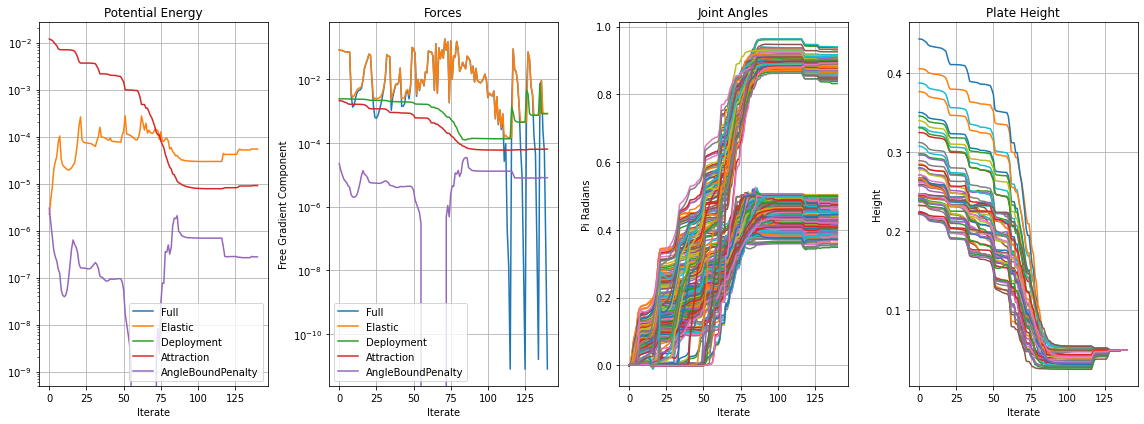

In [48]:
eqays.plot()

In [49]:
# use_pin = True

# driver = curr_um.centralJoint()
# jdo = curr_um.dofOffsetForJoint(driver)
# fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

# configure_umbrella_true_equlibrium(curr_um, thickness, target_height_multiplier)

# allEnergies(curr_um)

# OPTS.niter = 100

# results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

# results.success

0	-56.9999	6.42053e-05	6.42053e-05	1	1
1	-56.9999	2.6985e-05	2.6985e-05	1	1
2	-56.9999	7.3925e-05	7.3925e-05	1	1
3	-56.9999	0.000187919	0.000187919	1	1
4	-56.9999	0.00044676	0.00044676	0.015625	0
5	-56.9999	0.00701515	0.00701515	0.125	0
6	-56.9999	0.0179848	0.0179848	1	0
7	-56.9999	0.0334653	0.0334653	0.5	0
8	-56.9999	0.0326366	0.0326366	1	0
9	-56.9999	0.00709204	0.00709204	0.25	0
10	-56.9999	0.0167063	0.0167063	1	0
11	-56.9999	0.0118891	0.0118891	0.25	0
12	-56.9999	0.0106329	0.0106329	1	0
13	-57	0.00857681	0.00857681	0.5	0
14	-57	0.00768966	0.00768966	1	0
15	-57	0.00749338	0.00749338	1	0
16	-57	0.0131731	0.0131731	1	0
17	-57	0.00809413	0.00809413	0.5	0
18	-57	0.00871391	0.00871391	1	0
19	-57	0.00573869	0.00573869	0.5	0
20	-57	0.00702825	0.00702825	1	0
21	-57	0.00547325	0.00547325	0.5	0
22	-57	0.00602698	0.00602698	1	0
23	-57	0.00479022	0.00479022	0.5	0
24	-57	0.00523995	0.00523995	1	0
25	-57	0.00456411	0.00456411	0.5	0
26	-57	0.00479791	0.00479791	1	0
27	-57	0.00373283	0.00373283	0.5	

True

In [51]:
# import registration
# R, t = registration.register_points(curr_um.XJointPositions().reshape(-1,3), curr_um.XJointTgtPositions().reshape(-1,3))
# V = target_mesh.vertices()
# V_reg = R @ V.transpose() + np.repeat(t[:, np.newaxis],  len(V), axis = 1)
# target_mesh_reg = mesh.Mesh(V_reg.transpose(), target_mesh.elements())
# view2 = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh_reg, width=1024, height=600)
# set_surface_view_options(view2, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
# view2.averagedMaterialFrames = True
# view2.showScalarField(rod_colors)
# view2.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

In [52]:
# write_deformed_config(curr_um, output_path, output_path, write_stress = False, is_rest_state = False, handleBoundary = handleBoundary, reg_data = [R, t])

In [13]:
# use_pin = False

# driver = curr_um.centralJoint()
# jdo = curr_um.dofOffsetForJoint(driver)
# fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

### Initialize Design Optimization

In [14]:
configure_umbrella_optimization(curr_um)
# curr_um.scaleInputPosWeights(0)

import py_newton_optimizer
opt_opts = py_newton_optimizer.NewtonOptimizerOptions()
opt_opts.gradTol = 1e-8
opt_opts.verbose = 10
opt_opts.beta = 1e-6
opt_opts.niter = 600
opt_opts.verboseNonPosDef = False

results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = opt_opts, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

opt_opts.niter = 50

results.success

# import force_analysis
# force_analysis.UmbrellaForceAnalysis(curr_um)
# v2 = force_analysis.UmbrellaForceFieldVisualization(curr_um)
# v2.show()

0	-56.9999	6.40693e-05	6.40693e-05	0.015625	0
10	-56.9999	0.0166932	0.0166932	1	0
20	-57	0.00447078	0.00447078	1	0
30	-57	0.00148157	0.00148157	1	0


True

In [15]:
optimizer = umbrella_optimization.UmbrellaOptimization(curr_um, opt_opts, 2.5, -1, False, fixedVars)
curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

optimizer.beta = 1 * 1e6
optimizer.gamma = 1
optimizer.eta = 0
optimizer.zeta = 0# 1e1
optimizer.iota = 0

rest_height_optimizer = umbrella_optimization.UmbrellaRestHeightsOptimization(optimizer)
single_rest_height_optimizer = umbrella_optimization.UmbrellaSingleRestHeightOptimization(rest_height_optimizer)

rest_height_optimizer.newPt(rest_height_optimizer.params())

original_design_parameters = rest_height_optimizer.params()

doptays = DesignOptimizationAnalysis(rest_height_optimizer)
def eqm_callback(prob, i):
    eqays.record(prob)
    if (i % 2 == 0):
        view.showScalarField(rod_colors)

import time
pipeline_helper.prev_time_stamp = time.time()

uo = rest_height_optimizer.get_parent_opt()

uo.equilibriumOptimizer.options.verbose = 1
#uo.equilibriumOptimizer.options.verboseWorkingSet = True
uo.equilibriumOptimizer.options.gradTol = 1e-10
# Hold the closest points fixed in the target-attraction term of the equilibrium solve:
# this seems to make the design optimization much more robust.
uo.setHoldClosestPointsFixed(True, False)

In [16]:
tfview = pipeline_helper.TargetFittingVisualization(curr_um, uo.target_surface_fitter, view)
cb = pipeline_helper.UmbrellaOptimizationCallback(rest_height_optimizer, view, True, False, 1, rod_colors, doptays.record, tfview=tfview)

In [17]:
algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
#algorithm = umbrella_optimization.OptAlgorithm.BFGS
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 200, 0.005, 1e-5, cb, input_data["plate_edge_length"] / 30 * 32)

In [18]:
rest_height_optimizer.reset_joint_target_with_closest_points()

algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
#algorithm = umbrella_optimization.OptAlgorithm.BFGS
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 1000, 0.005, 1e-5, cb, input_data["plate_edge_length"] / 30 * 32)

In [19]:
# rest_height_optimizer.reset_joint_target_with_closest_points()
# curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

# algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
# #algorithm = umbrella_optimization.OptAlgorithm.BFGS
# solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 1000, 0.005, 1e-5, cb, input_data["plate_edge_length"] / 30 * 32)

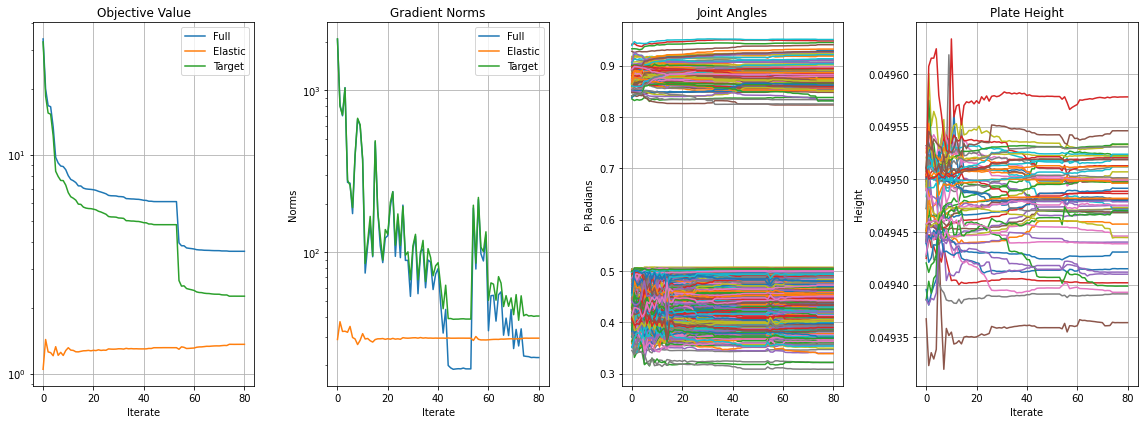

In [19]:
import time

from matplotlib import pyplot as plt
doptays.plot()

In [20]:
rest_height_optimizer.beta = 1 * 1e7
rest_height_optimizer.reset_joint_target_with_closest_points()
curr_um.scaleInputPosWeights(0.2, bdryMultiplier = 1.0)

algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 10000, 0.005, 1e-5, cb, input_data["plate_edge_length"] / 30 * 32)

In [21]:
rest_height_optimizer.beta, rest_height_optimizer.gamma, rest_height_optimizer.eta

(10000000.0, 1.0, 0.0)

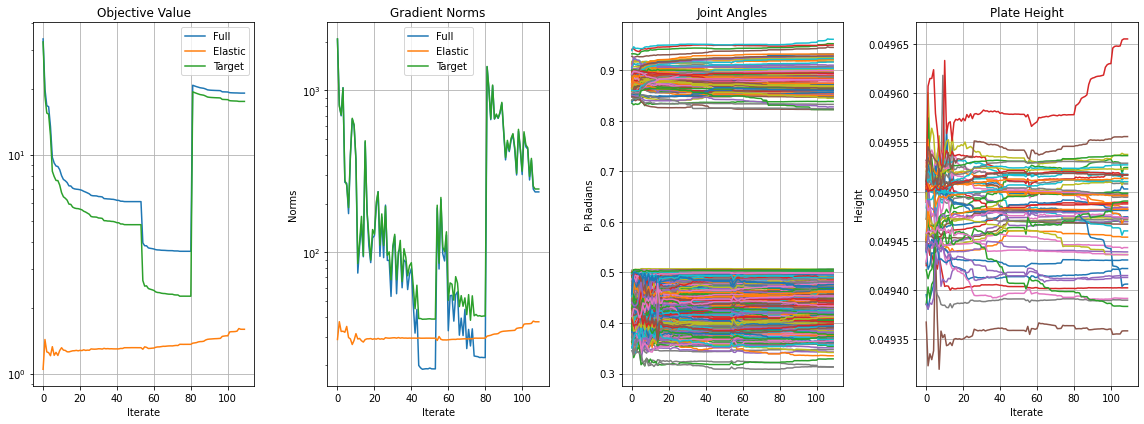

In [22]:
import time

from matplotlib import pyplot as plt
doptays.plot()

### Get true equilibrium state

In [23]:
use_pin = True

driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

configure_umbrella_true_equlibrium(curr_um, thickness, target_height_multiplier)

allEnergies(curr_um)

OPTS.niter = 100

results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

results.success

0	-56.9999	3.1958e-07	3.1958e-07	0.0625	0
1	-56.9999	0.000753566	0.000753566	1	0
2	-56.9999	0.000293444	0.000293444	0.25	0
3	-56.9999	0.000676643	0.000676643	1	0
4	-56.9999	2.15403e-05	2.15403e-05	0.25	0
5	-56.9999	0.00059733	0.00059733	1	0
6	-56.9999	2.06728e-05	2.06728e-05	0.5	0
7	-56.9999	0.00206722	0.00206722	1	0
8	-56.9999	1.19754e-06	1.19754e-06	0.125	0
9	-56.9999	0.000723977	0.000723977	1	0
10	-56.9999	7.3533e-06	7.3533e-06	0.25	0
11	-56.9999	0.000902552	0.000902552	1	0
12	-56.9999	3.45672e-06	3.45672e-06	0.25	0
13	-56.9999	0.00115967	0.00115967	1	0
14	-56.9999	1.39724e-06	1.39724e-06	0.25	0
15	-56.9999	0.00115016	0.00115016	1	0
16	-56.9999	8.68527e-07	8.68527e-07	0.25	0
17	-56.9999	0.000811706	0.000811706	1	0
18	-56.9999	1.02396e-06	1.02396e-06	0.5	0
19	-56.9999	0.00191154	0.00191154	1	0
20	-56.9999	1.04259e-07	1.04259e-07	0.5	0
21	-56.9999	0.000779727	0.000779727	1	0
22	-56.9999	9.20453e-08	9.20453e-08	1	0
23	-56.9999	0.000820201	0.000820201	1	0
24	-56.9999	1.66895e-08	1.66895

True

In [24]:
# import force_analysis
# force_analysis.UmbrellaForceAnalysis(curr_um)
# v2 = force_analysis.UmbrellaForceFieldVisualization(curr_um)
# v2.show()

In [24]:
# import registration
# R, t = registration.register_points(curr_um.XJointPositions().reshape(-1,3), curr_um.XJointTgtPositions().reshape(-1,3))
# V = target_mesh.vertices()
# V_reg = R @ V.transpose() + np.repeat(t[:, np.newaxis],  len(V), axis = 1)
# target_mesh_reg = mesh.Mesh(V_reg.transpose(), target_mesh.elements())
# view3 = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh_reg, width=1024, height=600)
# set_surface_view_options(view3, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
# view3.averagedMaterialFrames = True
# view3.showScalarField(rod_colors)
# view3.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

In [25]:
# assert 0
import pickle 
import gzip

pickle.dump(curr_um, gzip.open('../../data/optim/{}_optimized_equilibrium_{}_target_height_factor_{}.pkl.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"), target_height_multiplier), 'w'))
# load_um = pickle.load(gzip.open('test_pickle_um.pkl.gz', 'r'))
import importlib, load_jsondata
importlib.reload(load_jsondata)
load_jsondata.update_optimized_json(input_path, rest_height_optimizer.params(), output_json_path = '../../data/optim/{}_optimized_params_{}.json'.format(name, time.strftime("%Y_%m_%d_%H_%M")), optim_spacing_factor = target_height_multiplier, handleBoundary = handleBoundary)



In [27]:

from load_jsondata import write_deformed_config
output_path = '../../data/optim/{}_optimized_rendering_output_{}.json.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"))
write_deformed_config(curr_um, input_path, output_path, write_stress = False, is_rest_state = False, handleBoundary = handleBoundary)#, reg_data = [R,t])

### Undeployment

In [28]:
configure_umbrella_undeployment_step_one(curr_um, thickness, target_height_multiplier)

In [29]:
allEnergies(curr_um)

{'Full': -51.347740112767006,
 'Elastic': 7.508023639816277e-05,
 'Deployment': -51.347815941250275,
 'Repulsion': 0.0,
 'Attraction': 0.0,
 'AngleBoundPenalty': 7.48246868756692e-07}

In [30]:
OPTS.niter = 10

In [34]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)
results.success

0	-55.5748	0.212671	0.212671	1	1
1	-55.6325	0.679109	0.679109	1	1
2	-55.6593	0.383198	0.383198	1	1
3	-55.6687	0.114835	0.114835	1	1
4	-55.6773	0.0811024	0.0811024	1	1
5	-55.6917	0.0861607	0.0861607	1	1
6	-55.7163	0.138316	0.138316	1	1
7	-55.7568	0.487144	0.487144	1	1
8	-55.762	0.081492	0.081492	1	1
9	-55.7651	0.0531041	0.0531041	1	1
10	-55.7706	0.0527128	0.0527128	1	1


False

In [35]:
configure_umbrella_undeployment_step_two(curr_um)

In [36]:
allEnergies(curr_um)

{'Full': 0.5325465416608146,
 'Elastic': 0.531746559121092,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0,
 'AngleBoundPenalty': 0.0007999825397226792}

In [37]:
OPTS.niter = 500

In [38]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)
results.success

0	0.532547	1.65321	1.65321	1	1
1	0.14514	4.71168	4.71168	1	1
2	0.0428599	0.692632	0.692632	1	1
3	0.02442	2.1507	2.1507	1	1
4	0.0174742	0.169628	0.169628	1	1
5	0.0151347	0.177092	0.177092	1	1
6	0.012912	0.152014	0.152014	1	1
7	0.0108878	0.205426	0.205426	1	1
8	0.00914759	0.233108	0.233108	1	1
9	0.00781416	0.252467	0.252467	1	1
10	0.00780399	0.128045	0.128045	1	1
11	0.00749025	0.0704987	0.0704987	0.5	1
12	0.00741506	0.0408694	0.0408694	1	1
13	0.00730231	0.0148964	0.0148964	1	1
14	0.00722287	0.00631035	0.00631035	1	1
15	0.00710138	0.00861234	0.00861234	1	1
16	0.00688268	0.0205302	0.0205302	1	1
17	0.00650502	0.0522971	0.0522971	1	1
18	0.00592836	0.0943718	0.0943718	1	1
19	0.00527979	0.143398	0.143398	1	1
20	0.00510162	0.0200132	0.0200132	1	1
21	0.00501811	0.00544339	0.00544339	1	1
22	0.00488888	0.0105511	0.0105511	1	1
23	0.00465624	0.0301301	0.0301301	1	1
24	0.00428264	0.0548413	0.0548413	1	1
25	0.00380445	0.0937709	0.0937709	1	1
26	0.00349723	0.157459	0.157459	1	1
27	0.00321969	0.0516452	

True

In [39]:
import pickle 
import gzip

pickle.dump(curr_um, gzip.open('../../data/optim/{}_optimized_rest_state_{}_target_height_factor_{}.pkl.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"), target_height_multiplier), 'w'))
write_deformed_config(curr_um, output_path, output_path, write_stress = False, is_rest_state = True, handleBoundary = handleBoundary)

In [7]:
# import importlib, load_jsondata, time
# importlib.reload(load_jsondata)
# import json, gzip
# from load_jsondata import update_optimized_json
# input_data = json.load(gzip.open('../../data/optim/tigridia_optimized_params_2022_01_23_12_51.json'))
# handleBoundary = True
# name = 'tigridia'
# load_jsondata.update_optimized_json('../../data/optim/tigridia_optimized_params_2022_01_23_12_51.json', input_data['optim_heights'], output_json_path = '../../data/optim/{}_optimized_params_{}.json.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M")), optim_spacing_factor = 1, handleBoundary = handleBoundary)
